In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

C:\Users\sabatini\AppData\Local\Temp\ipykernel_9788\1223945538.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import torch
import numpy as np
import tensorly as tl
import scipy.signal
import matplotlib.pyplot as plt
import copy

In [5]:
import sys
sys.path.append(r'C:\Users\sabatini\Documents\GitHub')
%load_ext autoreload
%autoreload 2
from tensor_regression import standard_tensor_regression as STR
from tensor_regression import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import tensorly as tl

In [7]:
DEVICE = util.set_device(use_GPU=True)

no GPU available. Using CPU.


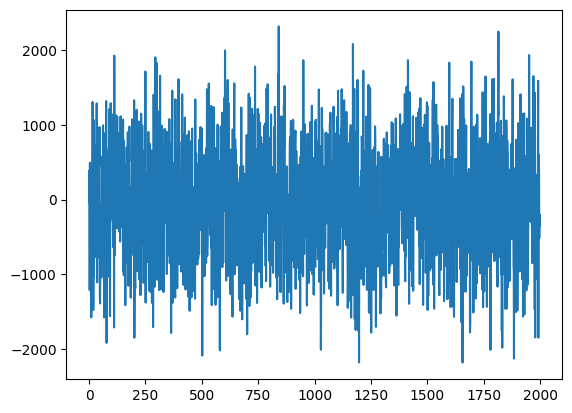

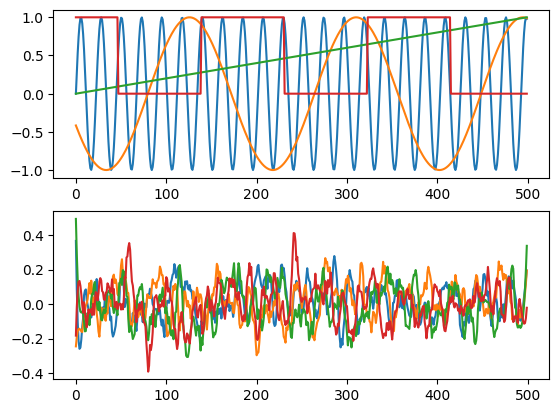

In [8]:
torch.manual_seed(321)
np.random.seed(321)

X_dims_fake = [2000, 500, 500]
nClasses_fake = 5

# y_true  = np.random.randint(0, nClasses_fake, X_dims_fake[0])
# y_true_oneHot = mtr.idx_to_oneHot(y_true, nClasses_fake)

Xcp_underlying_fake = [
                      torch.rand(X_dims_fake[0], 4)-0.5,
                      torch.vstack([torch.sin(torch.linspace(0, 140, X_dims_fake[1])),
                                    torch.cos(torch.linspace(2,19,X_dims_fake[1])),
                                    torch.linspace(0,1,X_dims_fake[1]),
                                    torch.cos(torch.linspace(0,17,X_dims_fake[1])) >0]).T,
                      torch.tensor(scipy.signal.savgol_filter(np.random.rand(X_dims_fake[2], 4), 15, 3, axis=0))-0.5,
                    ]
# Bcp_underlying_fake = Xcp_underlying_fake[1:] + [torch.rand(nClasses_fake, 4) -0.5]
Bcp_underlying_fake = Xcp_underlying_fake[1:]

tl.set_backend('pytorch')
X_fake = tl.cp_tensor.cp_to_tensor((np.ones(4), Xcp_underlying_fake))

y_hat = tl.tenalg.inner(X_fake + torch.rand(X_dims_fake)/100,
                    tl.cp_tensor.cp_to_tensor((np.ones(4), Bcp_underlying_fake )),
                    n_modes=len(Bcp_underlying_fake))

# y_trueProb_fake = mtr.model(X_fake, Bcp_underlying_fake, np.ones(4), [False, False, False])
# y_trueIdx_fake = torch.argmax(y_trueProb_fake, dim=1)

plt.figure()
plt.plot(y_hat)

fig, axs = plt.subplots(len(Bcp_underlying_fake))
for ii in range(len(axs)):
    axs[ii].plot(Bcp_underlying_fake[ii]);

In [ ]:
%load_ext autoreload
%autoreload 2
import basic_neural_processing_modules as bnpm
from basic_neural_processing_modules import torch_helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
X = copy.deepcopy(X_fake - X_fake.mean(0)).to(DEVICE)
y = copy.deepcopy(y_hat).to(DEVICE)

In [10]:
# h_vals = np.logspace(-50, 2, num=30, endpoint=True, base=10.0)
# h_vals = np.int64(np.linspace(1, 300, num=30, endpoint=True))
h_vals = np.array([1e-5])

loss_all = []
params_all = []
for ii, val in enumerate(h_vals):
    if 'cpmlr' in globals():
        print('deleting cpmlr')
        import gc
        del cpmlr
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
    
    
    print(f'hyperparameter val: {val}')
    cpmlr = STR.CP_linear_regression(X.shape, 
                                     dtype=X.dtype,
                                         rank=10,
                                         non_negative=[False, False],
                                         weights=None,
                                         Bcp_init=None,
                                         Bcp_init_scale=0.005,
                                         device=DEVICE,
                                         softplus_kwargs={
                                             'beta': 50,
                                             'threshold':1}
                                         )

    # tic = time.time()
    cpmlr.fit(X,y,lambda_L2=h_vals[ii], 
                max_iter=200, 
                tol=1e-50, 
                patience=10,
                verbose=2,
                running_loss_logging_interval=1,
                LBFGS_kwargs={
                    'lr' : 1, 
                    'max_iter' : 20, 
                    'max_eval' : None, 
                    'tolerance_grad' : 1e-07, 
                    'tolerance_change' : 1e-09, 
                    'history_size' : 100, 
                    'line_search_fn' : "strong_wolfe"
                }
             )
    
#     cpmlr.fit_Adam(lambda_L2=h_vals[ii], 
#                 max_iter=4000, 
#                 tol=1e-8, 
#                 patience=100,
#                 verbose=2,
#                 Adam_kwargs={
#                         'lr' : 0.0001, 
# #                             'betas' : (0.9, 0.999), 
# #                             'eps' : 1e-08, 
# #                             'weight_decay' : 0, 
#                         'amsgrad' : True
#                     }
#          )

    # print(time.time() - tic)
    print(f'loss: {cpmlr.loss_running[-1]}')
    
    loss_all.append(cpmlr.loss_running[-1])
    params_all.append(cpmlr.get_params())

hyperparameter val: 1e-05
Iteration: 0, Loss: 560125.5196947237  ;  Variance ratio (y_hat / y_true): 2.2449816820813365e-17
Iteration: 1, Loss: 1699.8925874402807  ;  Variance ratio (y_hat / y_true): 0.9410054224359876
Iteration: 2, Loss: 0.041904340578888165  ;  Variance ratio (y_hat / y_true): 0.9999999135134616
Iteration: 3, Loss: 0.041904340578888165  ;  Variance ratio (y_hat / y_true): 0.9999999135134616
Iteration: 4, Loss: 0.041904340578888165  ;  Variance ratio (y_hat / y_true): 0.9999999135134616
Iteration: 5, Loss: 0.041904340578888165  ;  Variance ratio (y_hat / y_true): 0.9999999135134616
Iteration: 6, Loss: 0.041904340578888165  ;  Variance ratio (y_hat / y_true): 0.9999999135134616
Iteration: 7, Loss: 0.041904340578888165  ;  Variance ratio (y_hat / y_true): 0.9999999135134616
Iteration: 8, Loss: 0.041904340578888165  ;  Variance ratio (y_hat / y_true): 0.9999999135134616
Iteration: 9, Loss: 0.041904340578888165  ;  Variance ratio (y_hat / y_true): 0.9999999135134616
Itera

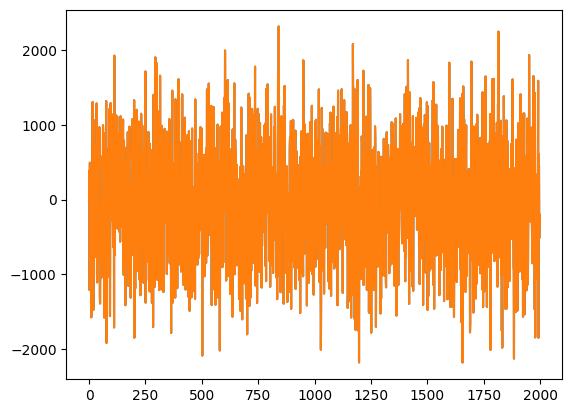

In [11]:
%matplotlib inline

y_pred = cpmlr.predict(X)

plt.figure()
plt.plot(y.cpu())
plt.plot(y_pred)

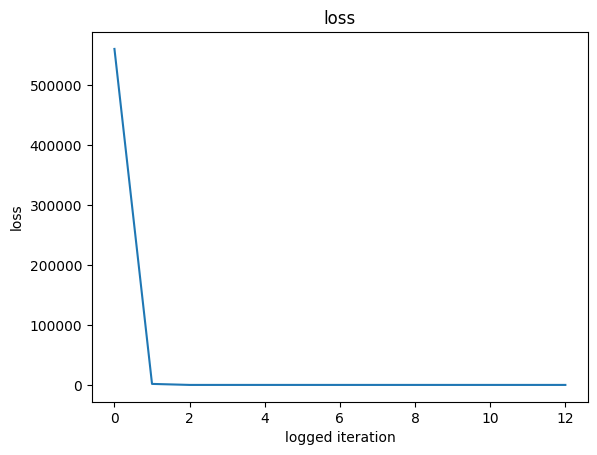

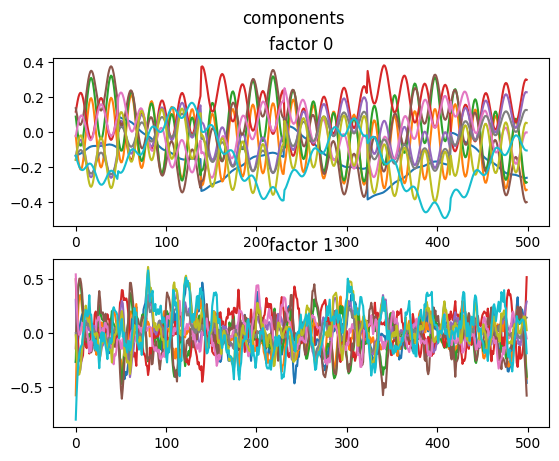

In [12]:
%matplotlib inline
cpmlr.plot_outputs()